# Project

## Names: Nitzan cohen, Idan Bar Oz, Yanai Bardos

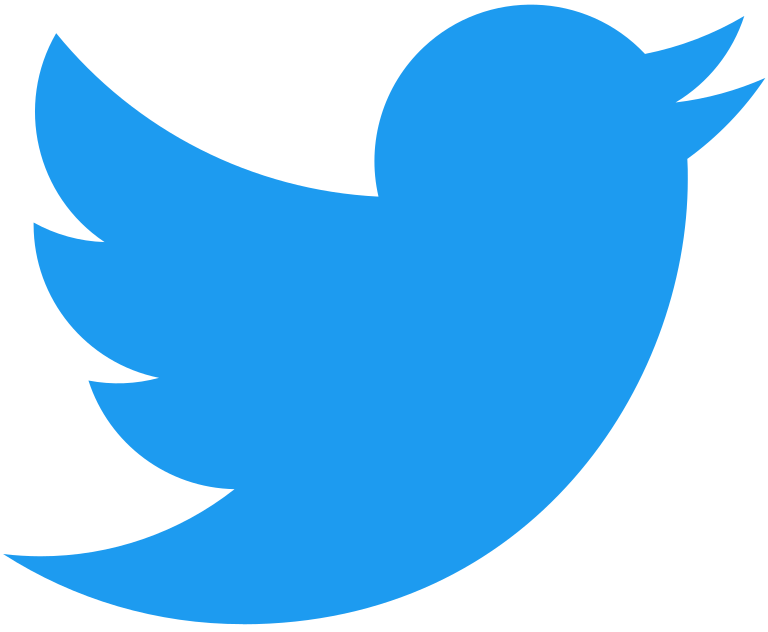,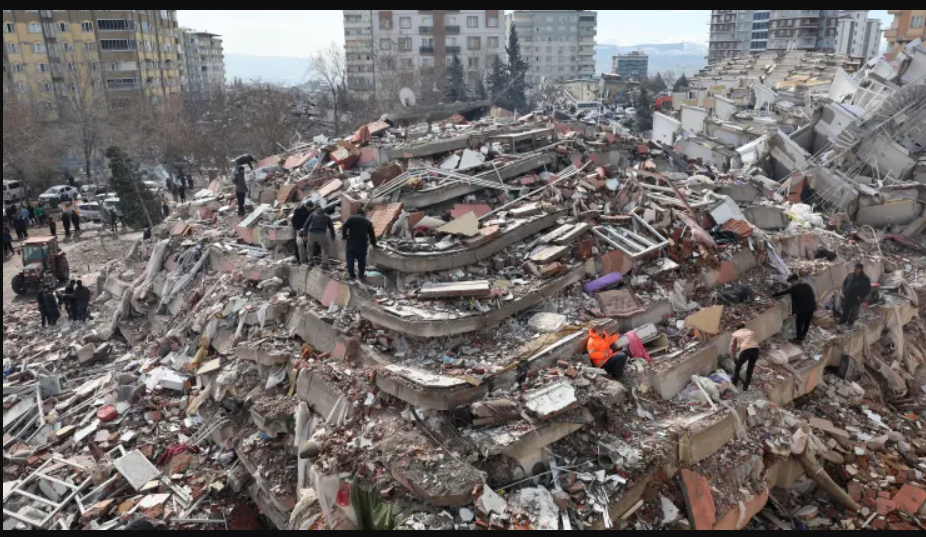

# The project aims to investigate the possibility of predicting whether a tweet from Twitter refers to a real disaster or not. In the project we studied 2 datasets of tweets in an attempt to predict whether certain characteristics of the tweet, such as an unusually high number of likes or whether the user is verified, can improve the ability to predict whether a tweet is related to a real disaster or not.

First of all let's import the necessary libraries 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.express as px
import nltk
import re
import plotly.figure_factory as ff
import warnings
import matplotlib as mpl
import os
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding,LSTM
from tensorflow.keras.preprocessing.text import Tokenizer  
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.tokenize.toktok import ToktokTokenizer
from keras_preprocessing import sequence  
from wordcloud import WordCloud
from collections import defaultdict
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2023-03-09 13:47:13.589105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# First problem: disaster or non disaster tweet?

In [2]:
df_train1 = pd.read_csv('train.csv')

In [3]:
df_test1 = pd.read_csv('Test1.csv')

## Let's take a look at our data

In [4]:
df_train1

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  

[7613 rows x 5 columns]

In [5]:
df_test1

id keyword location  \
0         0     NaN      NaN   
1         2     NaN      NaN   
2         3     NaN      NaN   
3         9     NaN      NaN   
4        11     NaN      NaN   
...     ...     ...      ...   
3258  10861     NaN      NaN   
3259  10865     NaN      NaN   
3260  10868     NaN      NaN   
3261  10874     NaN      NaN   
3262  10875     NaN      NaN   

                                                   text  target  
0                    Just happened a terrible car crash       1  
1     Heard about #earthquake is different cities, s...       1  
2     there is a forest fire at spot pond, geese are...       1  
3              Apocalypse lighting. #Spokane #wildfires       1  
4         Typhoon Soudelor kills 28 in China and Taiwan       1  
...                                                 ...     ...  
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...       0  
3259  Storm in RI worse than last hurricane. My city...       1  
3260  Green Line derailment in Chicago http://t.co/U...       1  
3261  MEG issues Hazardous Weather Outlook (HWO) htt...       1  
3262  #CityofCalgary has activated its Municipal Eme...       1  

[3263 rows x 5 columns]

For our prediction we will use text column only

Examples of non-disaster tweets

In [6]:
df_train1['text'][df_train1['target']==0]

15                                         What's up man?
16                                          I love fruits
17                                       Summer is lovely
18                                      My car is so fast
19                           What a goooooooaaaaaal!!!!!!
                              ...                        
7581    @engineshed Great atmosphere at the British Li...
7582    Cramer: Iger's 3 words that wrecked Disney's s...
7584    These boxes are ready to explode! Exploding Ki...
7587                                   Sirens everywhere!
7593    I just heard a really loud bang and everyone i...
Name: text, Length: 4342, dtype: object

We can see that the last three tweets can be confusing to our model because they have word like: explode, sirens and loud bang

Examples of disaster tweets

In [7]:
df_train1['text'][df_train1['target']==1]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 3271, dtype: object

## EDA Problem number 1 

Representations of non-disaster tweets and disaster tweets in the data

In [8]:
num_sample = len(df_train1['target'])
non_disaster_prob = sum(df_train1['target'] == 0) / num_sample
disaster_prob = sum(df_train1['target'] == 1) / num_sample
print('The percent of non-disaster tweets in the data: ',  non_disaster_prob)
print('The percent of disaster tweets in the data: ', disaster_prob)

The percent of non-disaster tweets in the data:  0.5703402075397347
The percent of disaster tweets in the data:  0.4296597924602653


Let's plot it

In [9]:
class_names = ['Non-disaster', 'Disaster']
n_images = [non_disaster_prob, disaster_prob]
px.pie(names=class_names, values=n_images, width=400, height=400)

It can be seen that there are more non-disaster tweets than disaster tweets as in real life, but the proportion in the data is less extreme

Now let's check the representations of each tweet's location in the data

When we look at our data, we notice that there are duplicate representations of the same locations, such as the US and the United States

In [10]:
df_train1['location'] = df_train1['location'].replace({'USA':'United States'})
df_test1['location'] = df_test1['location'].replace({'USA':'United States'})

In [11]:
location_count  = df_train1['location'].value_counts()
location_count = location_count[:10,]
plt.figure(figsize=(15,8))
sns.barplot(location_count.index, location_count.values, alpha=0.8)
plt.title('Top 10 locations')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('location', fontsize=12)
plt.show()

TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 1500x800 with 0 Axes>

We can see that most of the tweets come from developed countries and cities

Now let's check what are the top keywords of non-disaster tweets and disaster tweets

In [ ]:
kw_d = df_train1[df_train1['target']==1].keyword.value_counts().head(10)
kw_nd = df_train1[df_train1['target']==0].keyword.value_counts().head(10)

plt.figure(figsize=(20,5))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='c')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()


We can see that our data can confused our model because the top keywords for non-disasters tweets like: harm, armageddon, siren.

Let's check the distribution of length of tweets

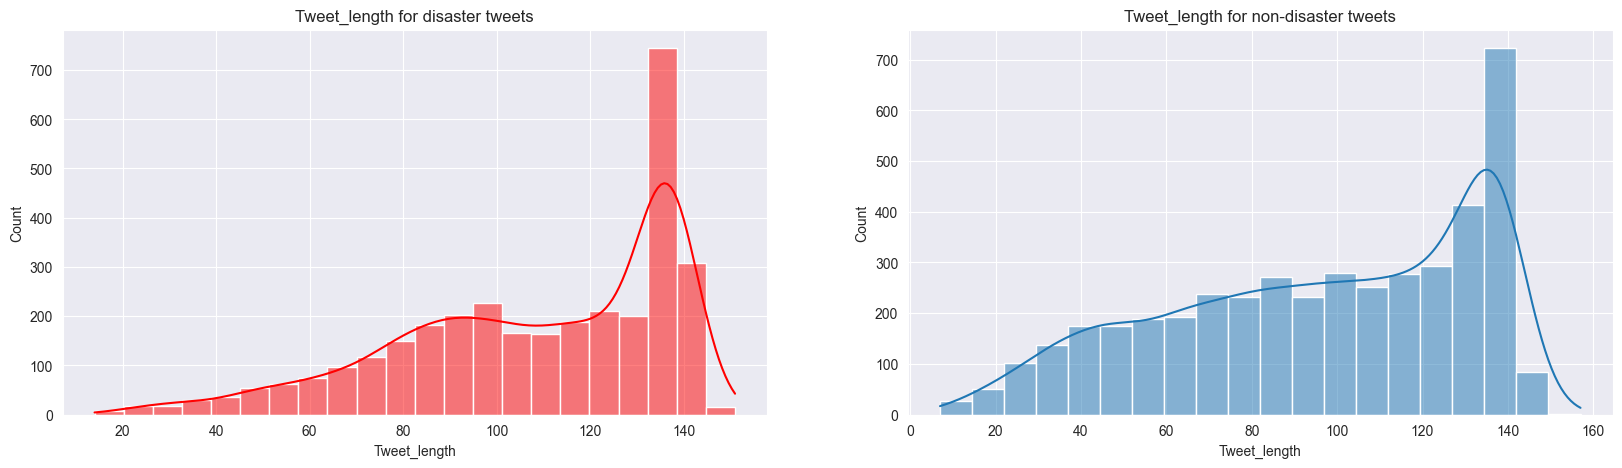

In [12]:
df_train1['Tweet_length'] = df_train1['text'].apply(lambda x: len(x))
plt.figure(figsize=(20,5))
plt.subplot(121)
sns.histplot(x = df_train1[df_train1['target']==1]['Tweet_length'], kde=True,color='r')
plt.title('Tweet_length for disaster tweets')
plt.subplot(122)
sns.histplot(x = df_train1[df_train1['target']==0]['Tweet_length'], kde=True)
plt.title('Tweet_length for non-disaster tweets')
plt.show()

We can see that the center of the disaster tweets is around 135 characters, on the other hand the center of the non-disaster tweets is around 140 characters

# Preprocessing of Problem 1

Let's clean the data and drop the special characters

In [13]:
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Define function for removing special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

# Removing the noisy text
def clean_text(text):
    text = remove_between_square_brackets(text)
    text=remove_special_characters(text)
    return text


# Apply function on text column
df_train1['text'] = df_train1['text'].apply(clean_text)
df_test1['text'] = df_test1['text'].apply(clean_text)

Let's download the stopwords in English

In [14]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nitzancohen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Removing stopwords

In [15]:
tqdm.pandas()
tokenizer = ToktokTokenizer()
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
df_train1['text_no_stopwords'] = df_train1['text'].progress_apply(remove_stopwords)
df_test1['text_no_stopwords'] = df_test1['text'].progress_apply(remove_stopwords)

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

We would like to check the most common words in disaster tweets

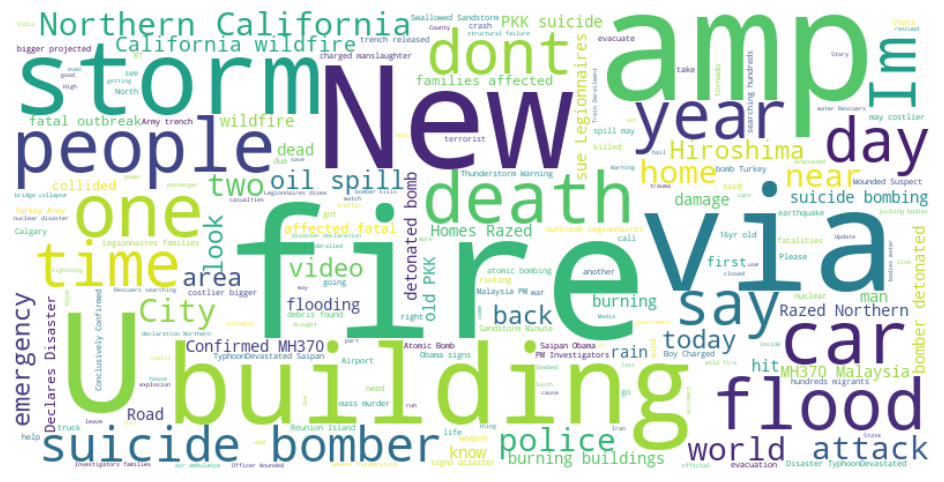

In [16]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df_train1['text_no_stopwords'][df_train1['target']==1]))
plt.figure(figsize=(20, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We can see that fire,New,Via and amp (that give information on electricity) are common words in disaster tweets

Now we will check the most common words in non-disaster tweets

In [17]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df_train1['text_no_stopwords'][df_train1['target']==0]))
plt.figure(figsize=(20, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We can see that Im and amp are common words in non-disaster tweets.

### It can be seen that there are some repeated words in both types of tweets

We would like to check the most common three word sequence in each label

In [18]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in stopword_list]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [19]:
# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train1['text'][df_train1['target']==1]:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in df_train1['text'][df_train1['target']==0]:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

Let's plot it

<AxesSubplot:>

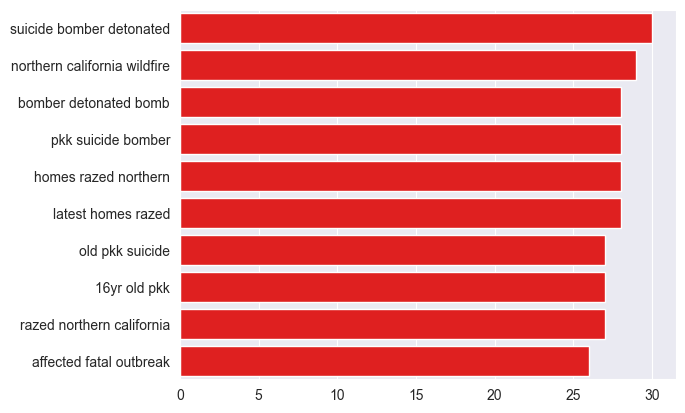

In [20]:
N=10
sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], color='red')

In [21]:
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], color='green')

<AxesSubplot:>

We can see that the most common trigrams in disaster tweets talk about booming.
On the other side, the most common trigrams in non-disaster tweets talk about Reddit and Youtube websites.

Word normalizaion with lemmatize

In [22]:
nltk.download('wordnet')
nltk.download('omw-1.4')
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(lemmatized_text)
# Apply function on data
df_train1['final_text'] =df_train1['text_no_stopwords'].progress_apply(lemmatize)
df_test1['final_text']=df_test1['text_no_stopwords'].progress_apply(lemmatize)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nitzancohen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nitzancohen/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

In [23]:
df_train1

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  Tweet_length  \
0     Our Deeds are the Reason of this earthquake Ma...       1            69   
1                 Forest fire near La Ronge Sask Canada       1            38   
2     All residents asked to shelter in place are be...       1           133   
3     13000 people receive wildfires evacuation orde...       1            65   
4     Just got sent this photo from Ruby Alaska as s...       1            88   
...                                                 ...     ...           ...   
7608  Two giant cranes holding a bridge collapse int...       1            83   
7609  ariaahrary TheTawniest The out of control wild...       1           125   
7610     M194 5km S of Volcano Hawaii httptcozDtoyd8EbJ       1            65   
7611  Police investigating after an ebike collided w...       1           137   
7612  The Latest More Homes Razed by Northern Califo...       1            94   

                                      text_no_stopwords  \
0          Deeds Reason earthquake May ALLAH Forgive us   
1                 Forest fire near La Ronge Sask Canada   
2     residents asked shelter place notified officer...   
3     13000 people receive wildfires evacuation orde...   
4     got sent photo Ruby Alaska smoke wildfires pou...   
...                                                 ...   
7608  Two giant cranes holding bridge collapse nearb...   
7609  ariaahrary TheTawniest control wild fires Cali...   
7610          M194 5km Volcano Hawaii httptcozDtoyd8EbJ   
7611  Police investigating ebike collided car Little...   
7612  Latest Homes Razed Northern California Wildfir...   

                                             final_text  
0           Deeds Reason earthquake May ALLAH Forgive u  
1                 Forest fire near La Ronge Sask Canada  
2     resident asked shelter place notified officer ...  
3     13000 people receive wildfire evacuation order...  
4     got sent photo Ruby Alaska smoke wildfire pour...  
...                                                 ...  
7608  Two giant crane holding bridge collapse nearby...  
7609  ariaahrary TheTawniest control wild fire Calif...  
7610          M194 5km Volcano Hawaii httptcozDtoyd8EbJ  
7611  Police investigating ebike collided car Little...  
7612  Latest Homes Razed Northern California Wildfir...  

[7613 rows x 8 columns]

Wק can see the differences between the processed text and the original text

Let's create x,y data for training

In [24]:
X_train=df_train1['final_text']
Y_train=df_train1['target']
X_test=df_test1['final_text']
Y_test=df_test1['target']

Train-valdiation split

In [25]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42, stratify = Y_train,shuffle=True)

let's check we split as we want

In [26]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)
print('x_test shape:', X_test.shape)
print('y_test shape:', Y_test.shape)

x_train shape: (6471,)
y_train shape: (6471,)
x_val shape: (1142,)
y_val shape: (1142,)
x_test shape: (3263,)
y_test shape: (3263,)


We will use tf-idf to convert words to vectors of numbers. since we have a lot of documents in the corpus we chose td-idf and not bag of words.

In [27]:
tfidf = TfidfVectorizer()
x_train_tf = tfidf.fit_transform(x_train).todense()
x_val_tf = tfidf.transform(x_val).todense()
X_test_tf = tfidf.transform(X_test).todense()

In [28]:
x_train_tf.shape[1]

19272

## Model selection

In [27]:
def run_DL(x_train, y_train, x_val=x_val_tf, y_val = y_val,input_dim=x_train_tf.shape[1]):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation='tanh'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3 ,batch_size=128)
    return model

In [28]:
def run_random_forest(x_train, y_train):
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(x_train, y_train)
    return clf

In [29]:
def run_Logistic_Regression(x_train, y_train):
    LR = LogisticRegression()
    LR.fit(x_train,y_train)
    return LR

In [30]:
def run_MultinomialNB(x_train, y_train):
    MNB = MultinomialNB()
    MNB.fit(x_train, y_train)
    return MNB

Let's run all models:

In [31]:
def run_all_models(x, y):
    models_dict = {'DL': run_DL(x, y), 'Random forest': run_random_forest(x, y),
                   'Logistic Regression': run_Logistic_Regression(x, y), 'MultinomialNB': run_MultinomialNB(x, y)}
    return models_dict

In [32]:
models = run_all_models(x_train_tf, y_train)
models

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                616736    
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 617,281
Trainable params: 617,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
51/51 [==============================] - 5s 45ms/step - loss: 0.6595 - accuracy: 0.6274 - val_loss: 0.5903 - val_accuracy: 0.7583
Epoch 2/3
51/51 [==============================] - 2s 34ms/step - loss: 0.4773 - accuracy: 0.8493 - val_loss: 0.4481 - val_accuracy: 0.8205
Epoch 3/3
51/51 [=================

{'DL': <keras.engine.sequential.Sequential at 0x1ddc4eed8b0>,
 'Random forest': RandomForestClassifier(n_estimators=200, random_state=42),
 'Logistic Regression': LogisticRegression(),
 'MultinomialNB': MultinomialNB()}

Now we will examine the models on the validation set

In [33]:
cv_scores = {'Random forest': accuracy_score(y_val, np.round(models['Random forest'].predict(x_val_tf))),
             'Logistic Regression': accuracy_score(y_val, np.round(models['Logistic Regression'].predict(x_val_tf))),
             'MultinomialNB': accuracy_score(y_val, np.round(models['MultinomialNB'].predict(x_val_tf))),
             'DL': accuracy_score(y_val, np.round(models['DL'].predict(x_val_tf)))}
cv_scores

36/36 [==============================] - 0s 2ms/step


{'Random forest': 0.787215411558669,
 'Logistic Regression': 0.8152364273204904,
 'MultinomialNB': 0.8126094570928196,
 'DL': 0.8222416812609457}

<AxesSubplot:>

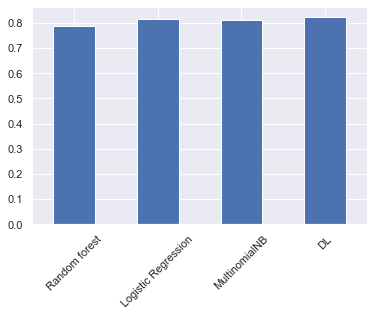

In [34]:
sns.set()
cv_scores_df = pd.DataFrame.from_dict(cv_scores, orient='index')
cv_scores_df.plot.bar(rot=45, legend=False)

We can see that the deep learning model is the best model

## Evaluating on test set

Let's evaluate on the test set:

In [35]:
y_preds = tf.round(models['DL'].predict(X_test_tf))
first_model_score = metrics.accuracy_score(Y_test, y_preds)
first_model_score

102/102 [==============================] - 0s 2ms/step


0.7958933496782102

Let's see our result in confusion matrix

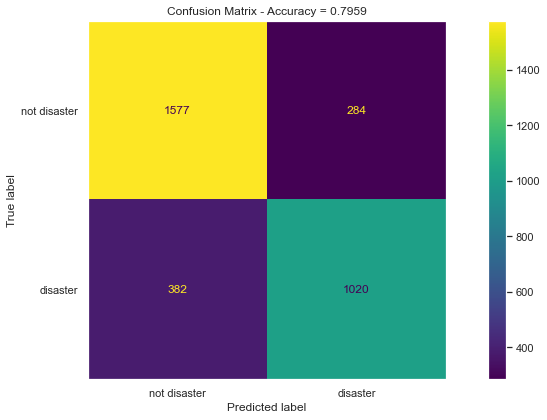

In [36]:
x_axes = ['not disaster','disaster']
y_axes =  ['not disaster','disaster']

fig,axes = plt.subplots(figsize=(12, 6))

martix = confusion_matrix(Y_test, y_preds)
ConfusionMatrixDisplay(martix).plot(ax=axes)
axes.title.set_text('Confusion Matrix - Accuracy = {:.4f}'.format(first_model_score))

axes.set_xticks(np.arange(len(x_axes)), labels=x_axes)
axes.set_yticks(np.arange(len(y_axes)), labels=y_axes)

plt.tight_layout()
plt.grid(False)
plt.show()

We can see that our False-Positive is larger than False-Negative

In [37]:
Y_test = np.array(Y_test)
y_preds = np.array(y_preds)

An example of one prediction that the model predicted a disaster but in practice it is not a disaster

In [38]:
predicted_disaster_but_was_wrong = np.where((Y_test == 0) & (y_preds== 1))
predicted_disaster_but_was_wrong = predicted_disaster_but_was_wrong[0]
i = X_test.index[predicted_disaster_but_was_wrong[5]]
df_test1['text'][i]

'Just happened a terrible car crash'

An example of one forecast that the model guessed was not a disaster but in practice it is a disaster

In [39]:
predicted_not_disaster_but_was_wrong = np.where((Y_test == 1) & (y_preds== 0))[0]
i1 = X_test.index[predicted_not_disaster_but_was_wrong[5]]
df_test1['text'][i1]

'Theyd probably still show more life than Arsenal did yesterday eh EH'

# Problem 2 - likes per tweet / user verified

The dataset contains tweets that are used #covid-19 as a hashtag

In [27]:
df_2 = pd.read_csv('covid19_tweets.csv', lineterminator='\n')

## Let's take a look on our data

In [28]:
df_2

username    user_display_name  \
0        Reporterroblang     Robert Lang WBAL   
1        Reporterroblang     Robert Lang WBAL   
2        Reporterroblang     Robert Lang WBAL   
3        Reporterroblang     Robert Lang WBAL   
4             FritzLang7           Fritz Lang   
...                  ...                  ...   
1938808         Kyusibot            Kyusi Bot   
1938809         Kyusibot            Kyusi Bot   
1938810    SherbInnopole  Sherbrooke Innopole   
1938811   ChrisStrategic        Chris Jackson   
1938812   ClauCristobalC    Claudia Cristóbal   

                                          user_description    user_location  \
0        Reporter and Anchor at WBAL NewsRadio 1090 & F...    Baltimore, MD   
1        Reporter and Anchor at WBAL NewsRadio 1090 & F...    Baltimore, MD   
2        Reporter and Anchor at WBAL NewsRadio 1090 & F...    Baltimore, MD   
3        Reporter and Anchor at WBAL NewsRadio 1090 & F...    Baltimore, MD   
4                                                      NaN              NaN   
...                                                    ...              ...   
1938808          I'm just a bot and life is a nightmare♪♥♪              NaN   
1938809          I'm just a bot and life is a nightmare♪♥♪              NaN   
1938810  L’organisme de développement économique du sec...       Sherbrooke   
1938811  Director + Partner @FuturesWeCreate. #OODA adv...  Wellington | NZ   
1938812  Chula Oaxaqueña. Periodista/Reportera de Notic...   Oaxaca, México   

         user_verified  user_protected  user_followers_count  \
0                False           False                  9714   
1                False           False                  9714   
2                False           False                  9714   
3                False           False                  9714   
4                False           False                    37   
...                ...             ...                   ...   
1938808          False           False                     3   
1938809          False           False                     3   
1938810          False           False                  3174   
1938811          False           False                  1633   
1938812          False           False                   131   

         user_friends_count  user_statuses_count  user_favourites_count  \
0                      4430               127497                  36210   
1                      4430               127497                  36210   
2                      4430               127497                  36210   
3                      4430               127497                  36210   
4                       180                  777                   3020   
...                     ...                  ...                    ...   
1938808                   4                  759                      2   
1938809                   4                  759                      2   
1938810                1438                 7992                   1641   
1938811                 375                27595                   2909   
1938812                 312                  756                   1984   

                                             tweet_content tweet_language  \
0        From the inbox---These are the first prescipti...             en   
1        From the inbox:  @GovLarryHogan and @MDHealthD...             en   
2        From the inbox: Baltimore City Councilman Yitz...             en   
3        BREAKING---@MDHealthDept has updated the death...             en   
4        @GitGrumpygit @ABridgen It seems @ABridgen and...             en   
...                                                    ...            ...   
1938808  #Covid19 Update! #SaudiArabia #KSA 🇸🇦 🇸🇦 🇸🇦 To...             en   
1938809  #Covid19 Update! #Philippines #Ph 🇵🇭 🇵🇭 🇵🇭 Tod...             en   
1938810  Immunotherapy against #COVID19: #Sherbrooke-ba...             en   
1938811  @nealejones You mean the "get

The data contains the following information:<br>

*Username: Username of the person who tweeted<br>
*User Display Name: Name of the person who tweeted<br>
*User Description: Description of the person who tweeted<br>
*User Location: Location of the person who tweeted<br>
*User Verified: Whether the person who tweeted is verified <br>
*User Followers Count: Number of followers of the person who tweeted<br>
*User Friends Count: Number of friends of the person who tweeted<br>
*User Statuses Count: Number of tweets of the person who tweeted<br>
*User Favourites Count: Number of favourites of the person who tweeted<br>
*Tweet Content: Content of the tweet<br>
*Tweet Language: Language of the tweet<br>
*Tweet Retweet Count: Number of retweets of the tweet<br>
*Tweet Quote Count: Number of quotes of the tweet<br>
*Tweet Reply Count: Number of replies of the tweet<br>
*Tweet Like Count: Number of likes of the tweet<br>
*Tweet Date: Date of the tweet<br>

We can see that there are diffrent languages in the data, let's see how many

In [29]:
df_2['tweet_language'].nunique()

64

Let's take only the English content

In [30]:
tweets_en_df = df_2.loc[df_2['tweet_language']=='en']

We sort the data by date to split the data correctly. That is, the earlier observations will be in the training data and the later observations will be in the test data.

In [31]:
tweets_en_df = tweets_en_df.sort_values(by='tweet_date')

Split for train and test

In [32]:
df_train2 = tweets_en_df.sample(frac=0.8,random_state=200)
df_test2 = tweets_en_df.drop(df_train2.index)

In [33]:
df_train2.shape

(785766, 19)

Since we have to lower the dimensionality of the data, we'd like to filter the data by leaving the tweets, tweeted by users who have more followers than the median, and the tweets tweeted by users who tweeted more than the median

In [34]:
df_train2 = df_train2.loc[df_train2['user_followers_count']>=df_train2['user_followers_count'].median()]
df_test2 = df_test2.loc[df_test2['user_followers_count']>=df_train2['user_followers_count'].median()]

In [35]:
df_train2 = df_train2.loc[df_train2['user_statuses_count']>=df_train2['user_statuses_count'].median()]
df_test2 = df_test2.loc[df_test2['user_statuses_count']>=df_train2['user_statuses_count'].median()]

In [36]:
df_train2.shape

(198567, 19)

In [37]:
df_test2.shape

(16987, 19)

We want to drop some columns that we don't need to our EDA

In [38]:
df_train2 = df_train2.drop(['tweet_url','tweet_language', 'user_display_name','user_protected'], axis=1)

## EDA Problem number 2 - likes

When we take a look at our data we notice there are duplicate representions of same locations, like USA and United States

In [39]:
df_train2['user_location'] = df_train2['user_location'].replace({'USA':'United States','New Delhi, India': 'New Delhi' ,'London, England': 'London', 'New York, NY': 'New York'})

Representations of each location of tweet in the data

In [40]:
location_count  = df_train2['user_location'].value_counts()
location_count = location_count[:10,]
plt.figure(figsize=(15,8))
sns.barplot(location_count.index, location_count.values, alpha=0.8)
plt.title('Top 10 locations')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('location', fontsize=12)
plt.show()

We can see that most of the tweets come from developed countries and cities

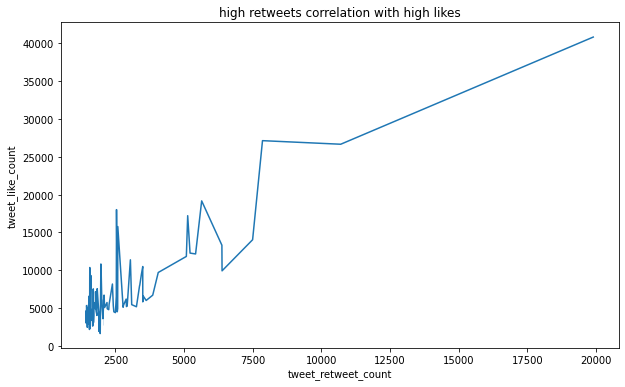

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
retweets = df_train2.sort_values(by="tweet_retweet_count",ascending=False)
retweets = retweets[:100]
sns.lineplot(data=retweets,x="tweet_retweet_count",y="tweet_like_count",ax=ax)
ax.set(xlabel='tweet_retweet_count', ylabel='tweet_like_count',title="high retweets correlation with high likes")
plt.show()

Let's deal with the tweet_date variable

In [42]:
def time_process(df):
    df['tweet_date'] = pd.to_datetime(df['tweet_date'], errors='coerce')
    df['datetime_year'] = df['tweet_date'].dt.year
    df['datetime_month'] = df['tweet_date'].dt.month_name()
    df['datetime_hour'] = df['tweet_date'].dt.hour
    df['datetime_dayofweek'] = df['tweet_date'].dt.day_name()
    df = df.drop(['tweet_date'], axis=1)
    return df

df_train2 = time_process(df_train2)
df_test2 = time_process(df_test2)

We can see that the most common words is: COVID19, vaccine, case and amp

Word normalization with lemmatize

In [47]:
df_train2['tweet_content'] = df_train2['tweet_content'].progress_apply(lemmatize)
df_test2['tweet_content'] = df_test2['tweet_content'].progress_apply(lemmatize)

  0%|          | 0/198567 [00:00<?, ?it/s]

  0%|          | 0/16987 [00:00<?, ?it/s]

Let's take a look at the amount of tweets with less than 60 likes

<AxesSubplot:xlabel='tweet_like_count', ylabel='Count'>

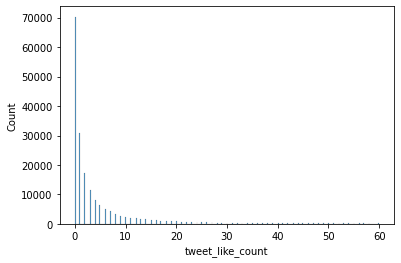

In [48]:
sns.histplot(df_train2[df_train2['tweet_like_count'] <= 60]['tweet_like_count'])

since we see here a long tail, we want to explore the outliers

We want to find the outlier tweets with the highest likes. We have determined that 5% is considered an outlier.

In [49]:
df_train2['tweet_like_count'].quantile(0.95)

58.0

so 58 likes and above per tweet is considered outlier.

In [50]:
df_train2['outlier likes']=0

df_train2['outlier likes'][(df_train2['tweet_like_count'] >= 0) & (df_train2['tweet_like_count'] < 58)]=0
df_train2['outlier likes'][(df_train2['tweet_like_count'] >= 58)]=1


Text(0.5, 1.0, 'Value Counts in Train')

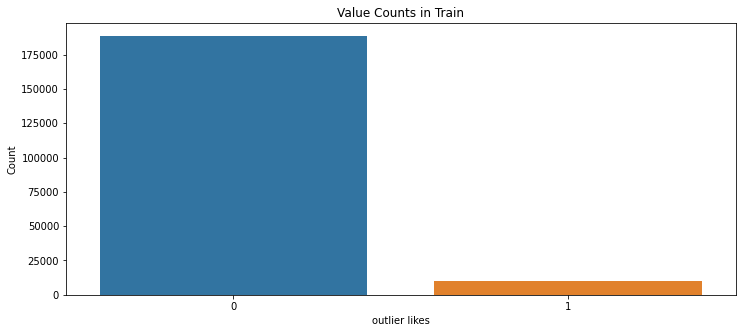

In [51]:
plt.figure(figsize=(12,5))
sns.countplot(x='outlier likes', data=df_train2)
# Set the axis labels and title
plt.xlabel('outlier likes')
plt.ylabel('Count')
plt.title('Value Counts in Train')

We will create the column for the test

In [52]:
df_test2['outlier likes']=0

df_test2['outlier likes'][(df_test2['tweet_like_count'] >= 0) & (df_test2['tweet_like_count'] < 58 )] = 0
df_test2['outlier likes'][(df_test2['tweet_like_count'] >= 58)] = 1


Text(0.5, 1.0, 'Value Counts in Test')

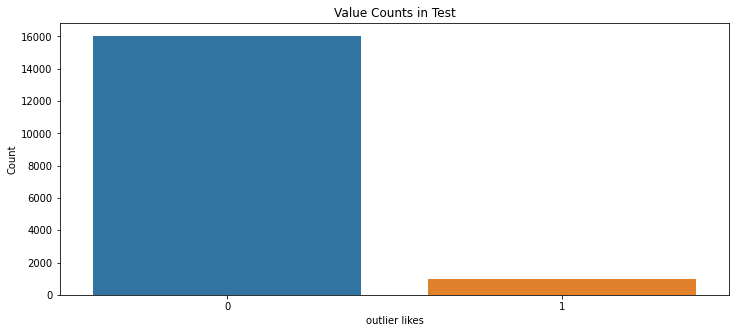

In [53]:
plt.figure(figsize=(12,5))
sns.countplot(x='outlier likes', data=df_test2)
# Set the axis labels and title
plt.xlabel('outlier likes')
plt.ylabel('Count')
plt.title('Value Counts in Test')

Let's create x,y data for training

In [54]:
X_train_l = df_train2['tweet_content']
Y_train_l = df_train2['outlier likes']
X_test_l = df_test2['tweet_content']
Y_test_l = df_test2['outlier likes']

Train-validition split

In [55]:
x_train_l, x_val_l, y_train_l, y_val_l = train_test_split(X_train_l, Y_train_l, test_size=0.1, random_state=42,shuffle=True)

Let's check we split as we want

In [56]:
print('x_train shape:', x_train_l.shape)
print('y_train shape:', y_train_l.shape)
print('x_val shape:', x_val_l.shape)
print('y_val shape:', y_val_l.shape)
print('x_test shape:', X_test_l.shape)
print('y_test shape:', Y_test_l.shape)

x_train shape: (178710,)
y_train shape: (178710,)
x_val shape: (19857,)
y_val shape: (19857,)
x_test shape: (16987,)
y_test shape: (16987,)


We satisfied with this split because the validation and train sets have the same shape(approximately)

We will use Keras' tokenizer to replace words with numbers for the training

In [57]:
token = Tokenizer(lower=False)
token.fit_on_texts(x_train_l)

In [58]:
x_train_dl = token.texts_to_sequences(x_train_l)
x_val_dl = token.texts_to_sequences(x_val_l)
x_test_dl = token.texts_to_sequences(X_test_l)

We have to make sure that all the text have the same length

In [59]:
df_train2['Tweet_length'] = df_train2['tweet_content'].apply(lambda x: len(x))
max_words2 = int(df_train2['Tweet_length'].mean())
max_words2

147

In [60]:
x_train_dl = sequence.pad_sequences(x_train_dl, maxlen=max_words2)
x_val_dl = sequence.pad_sequences(x_val_dl, maxlen=max_words2)
x_test_dl = sequence.pad_sequences(x_test_dl, maxlen=max_words2)

In [61]:
total_words2 = len(token.word_index) + 1
total_words2

313020

## Model 2 - likes

In [62]:
model = Sequential()
model.add(Embedding(input_dim=total_words2, output_dim=8, input_length=max_words2))
model.add(tf.keras.layers.LSTM(128))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 147, 8)            2504160   
                                                                 
 lstm (LSTM)                 (None, 128)               70144     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 16)                1

In [63]:
callback_likes = [
    tf.keras.callbacks.ModelCheckpoint("model_likes2.h5")
]

In [64]:
if not os.path.exists("model_likes2.h5"):
    model.fit(x_train_dl, y_train_l, validation_data=(x_val_dl, y_val_l), epochs=3, batch_size=1024,callbacks=callback_likes)

In [65]:
if os.path.exists('model_likes2.h5'):
    model = tf.keras.models.load_model('model_likes2.h5')

In [66]:
y_pred2 = model.predict(x_test_dl)

531/531 [==============================] - 18s 33ms/step


In [67]:
y_pred_labels = np.round(y_pred2)
Acc = accuracy_score(Y_test_l, y_pred_labels)
Acc

0.9046329546123506

In [68]:
recall_score = metrics.recall_score(Y_test_l, y_pred_labels)
recall_score

0.26569037656903766

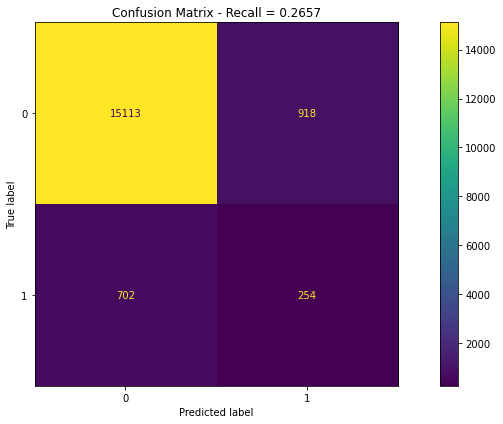

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

martix = confusion_matrix(Y_test_l, y_pred_labels)
ConfusionMatrixDisplay(martix).plot(ax=axes)
axes.title.set_text('Confusion Matrix - Recall = {:.4f}'.format(recall_score))

plt.tight_layout()
plt.grid(False)
plt.show()

### Although the accuracy percentage is high, the model fails to predict outliers well. This can be seen according to the recall metric.

## EDA Problem number 2 - user verified

We want to see the distribution of user_verified in the data

In [70]:
px.pie(df_train2,'user_verified', width=400, height=400,title='Distribution of user_verified in the data')

We can see we have more unverified users than verified users

Let's see the distribution of tweet length by verified / not verified users

In [71]:
plt.figure(figsize=(20,5))
plt.subplot(121)
sns.histplot(x = df_train2[df_train2['user_verified']==1]['Tweet_length'], kde=True,color='r')
plt.title('Tweet_length for verified users')
plt.subplot(122)
sns.histplot(x = df_train2[df_train2['user_verified']==0]['Tweet_length'], kde=True)
plt.title('Tweet_length for unverified users')
plt.show()

We can see there a difference in the tweet length when the user is verified or not. the biggest difference is in the middle of the distribution (200 length), when verified users have more tweets than the unverified users.

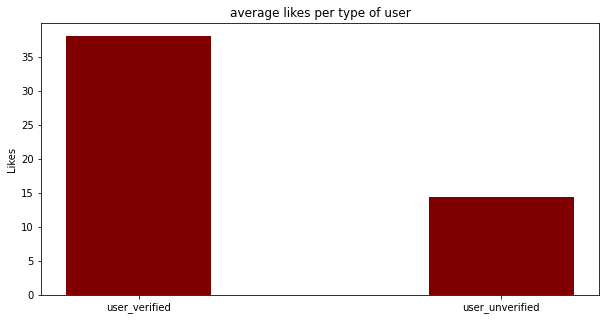

In [72]:
user_verified = df_train2.loc[df_train2['user_verified'] == True,'tweet_like_count'].mean()
user_unverified = df_train2.loc[df_train2['user_verified'] == False,'tweet_like_count'].mean()
# creating the dataset
data = {'user_verified':user_verified, 'user_unverified':user_unverified}
user_verified_or_not = list(data.keys())
means = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(user_verified_or_not, means, color ='maroon',
        width = 0.4)
plt.ylabel("Likes")
plt.title("average likes per type of user")
plt.show()

We can see that verified users have more likes in average than unverified users.

# Preprocessing Problem 2 - user verified

we want to switch user_verified to numeric values

In [73]:
df_train2['user_verified'] = df_train2['user_verified'].replace({True:1,False:0})
df_test2['user_verified'] = df_test2['user_verified'].replace({True:1,False:0})

In [74]:
X_train2=df_train2['tweet_content']
Y_train2=df_train2['user_verified']
X_test2=df_test2['tweet_content']
Y_test2=df_test2['user_verified']

Train-validition split

In [75]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(X_train2, Y_train2, test_size=0.1, random_state=42,shuffle=True)

Let's check we split as we want

In [76]:
print('x_train shape:', x_train2.shape)
print('y_train shape:', y_train2.shape)
print('x_val shape:', x_val2.shape)
print('y_val shape:', y_val2.shape)
print('x_test shape:', X_test2.shape)
print('y_test shape:', Y_test2.shape)

x_train shape: (178710,)
y_train shape: (178710,)
x_val shape: (19857,)
y_val shape: (19857,)
x_test shape: (16987,)
y_test shape: (16987,)


We satisfied with this split because the validation and train sets have the same shape(approximately)

We will use Keras' tokenizer to replace words with numbers for the training

In [77]:
token = Tokenizer(lower=False)
token.fit_on_texts(x_train2)

In [78]:
x_train_dl2 = token.texts_to_sequences(x_train2)
x_val_dl2 = token.texts_to_sequences(x_val2)
x_test_dl2 = token.texts_to_sequences(X_test2)

We have to make sure that all the text have the same length

In [79]:
x_train_dl2 = sequence.pad_sequences(x_train_dl2, maxlen=max_words2)
x_val_dl2 = sequence.pad_sequences(x_val_dl2, maxlen=max_words2)
x_test_dl2 = sequence.pad_sequences(x_test_dl2, maxlen=max_words2)

In [80]:
total_words2 = len(token.word_index) + 1 
total_words2

313020

## Model 2 - user verified

In [81]:
model2 = Sequential()
model2.add(Embedding(total_words2, 8,input_length = max_words2))
model2.add(LSTM(128, dropout=0.2))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam',
               metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 147, 8)            2504160   
                                                                 
 lstm_1 (LSTM)               (None, 128)               70144     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,574,433
Trainable params: 2,574,433
Non-trainable params: 0
_________________________________________________________________


In [82]:
callbacks_verified = [
   tf.keras.callbacks.ModelCheckpoint("Verified_model.h5", save_best_only=True)
]

In [83]:
if not os.path.exists("Verified_model.h5"):
    model2.fit(x_train_dl2, y_train2, validation_data=(x_val_dl2, y_val2), epochs=3 ,batch_size=1028,callbacks = callbacks_verified)

In [84]:
if os.path.exists('Verified_model.h5'):
    model2 = tf.keras.models.load_model('Verified_model.h5')

In [85]:
y_preds2 = np.round(model2.predict(x_test_dl2))
Verified_model_score=metrics.accuracy_score(Y_test2, y_preds2)

531/531 [==============================] - 16s 29ms/step


In [86]:
x_axes_v = ['user  not verified','user verified']
y_axes_v =  ['user not verified','user verified']

fig,axes = plt.subplots(figsize=(12, 6))

martix = confusion_matrix(Y_test2, y_preds2)
ConfusionMatrixDisplay(martix).plot(ax=axes)
axes.title.set_text('Confusion Matrix - Accuracy = {:.4f}'.format(Verified_model_score))

axes.set_xticks(np.arange(len(x_axes_v)), labels=x_axes_v)
axes.set_yticks(np.arange(len(y_axes_v)), labels=y_axes_v)

plt.tight_layout()
plt.grid(False)
plt.show()

# Problem 3 - let's check if we can improve our results of problem 1 using problem 2

We want to check the results with 3 options of columns adding: likes column, verify column and both. we want to see if it will help the predictive capabilities of the first model(whether the tweet is talking about disaster or not). it's unsupervised since we haven't the labels.

In [ ]:
def create_verified_column(x):
    token.fit_on_texts(x)
    text = token.texts_to_sequences(x)
    text = sequence.pad_sequences(text, maxlen=max_words2)
    verified = tf.round(model2.predict(text))
    return verified

In [ ]:
def create_likes_column(x):
    token.fit_on_texts(x)
    text = token.texts_to_sequences(x)
    text = sequence.pad_sequences(text, maxlen=max_words2)
    likes = tf.round(model.predict(text))
    return likes

We want to represent each of our tweets as a feature vector where each position in the vector represents a word/term and its value is the word's tf-idf value. Then we concatenate each tweet's tf-idf vector with the verified column we have and stack each of these vectors on top of each other to get a matrix.

In [ ]:
features = tfidf.get_feature_names()

In [ ]:
def prep_data_to_problem1_verified(df,df_tf):
    df_verified = create_verified_column(df)
    df = pd.DataFrame(data=df_tf, columns=features)
    df['user_verified'] = df_verified
    df = df.to_numpy()
    return df

def prep_data_to_problem1_likes(df,df_tf):
    df_likes = create_likes_column(df)
    df = pd.DataFrame(data=df_tf, columns=features)
    df['likes'] = df_likes
    df = df.to_numpy()
    return df

def prep_data_to_problem1_verified_and_likes(df,df_tf):
    df_likes = create_likes_column(df)
    df_verified = create_verified_column(df)
    df = pd.DataFrame(data=df_tf, columns=features)
    df['user_verified'] = df_verified
    df['likes'] = df_likes
    df = df.to_numpy()
    return df

now we will check the result with our new data using Deep Learning

In [ ]:
def get_models(x):
    if x == 'verify':
        new_x_train = prep_data_to_problem1_verified(x_train,x_train_tf)
        new_x_val = prep_data_to_problem1_verified(x_val,x_val_tf)
        new_x_test = prep_data_to_problem1_verified(X_test,X_test_tf)
    elif x == 'likes':
        new_x_train = prep_data_to_problem1_likes(x_train,x_train_tf)
        new_x_val = prep_data_to_problem1_likes(x_val,x_val_tf)
        new_x_test = prep_data_to_problem1_likes(X_test,X_test_tf)
    else:
        new_x_train = prep_data_to_problem1_verified_and_likes(x_train,x_train_tf)
        new_x_val = prep_data_to_problem1_verified_and_likes(x_val,x_val_tf)
        new_x_test = prep_data_to_problem1_verified_and_likes(X_test,X_test_tf)
    model = run_DL(new_x_train, y_train, new_x_val, y_val, input_dim=new_x_train.shape[1])
    return model, new_x_test

In [ ]:
def run_dl_all_data():
    models_dict = {'Only Verify': get_models('verify'), 'Only Likes': get_models('likes'),
                   'Likes And Verify': get_models('verify_and_likes')}
    return models_dict

It is possible and only after running the above function 3 times does it work

In [ ]:
models2 = run_dl_all_data()

102/102 [==============================] - 3s 27ms/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 32)                616768    
                                                                 
 dense_22 (Dense)            (None, 16)                528       
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 617,313
Trainable params: 617,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
51/51 [==============================] - 2s 20ms/step - loss: 0.6469 - accuracy: 0.6268 - val_loss: 0.5729 - val_accuracy: 0.7618
Epoch 2/3
51/51 [==============================] - 1s 15ms/step - loss: 0.4662 - accuracy: 0.8331 - val_loss: 0.4705

## Let's evaluate the models on the test set

In [ ]:
# this cell is only for readability
new_x_test_verified = models2['Only Verify'][1]
model_verify = models2['Only Verify'][0]

new_x_test_likes = models2['Only Likes'][1]
model_likes = models2['Only Likes'][0]

new_x_test_likes_and_verify = models2['Likes And Verify'][1]
model_likes_and_verify = models2['Likes And Verify'][0]

In [ ]:
cv_final_scores = {'Only Verify': accuracy_score(Y_test, tf.round(model_verify.predict(new_x_test_verified))),
                   'Only Likes': accuracy_score(Y_test, tf.round(model_likes.predict(new_x_test_likes))),
                   'Likes And Verify': accuracy_score(Y_test, tf.round(model_likes_and_verify.predict(new_x_test_likes_and_verify))),
                   'First Model': first_model_score}
cv_final_scores

102/102 [==============================] - 0s 3ms/step


{'Only Verify': 0.7977321483297579,
 'Only Likes': 0.796812749003984,
 'Likes And Verify': 0.7974256818878332,
 'First Model': 0.7958933496782102}

## Let's plot our final results !

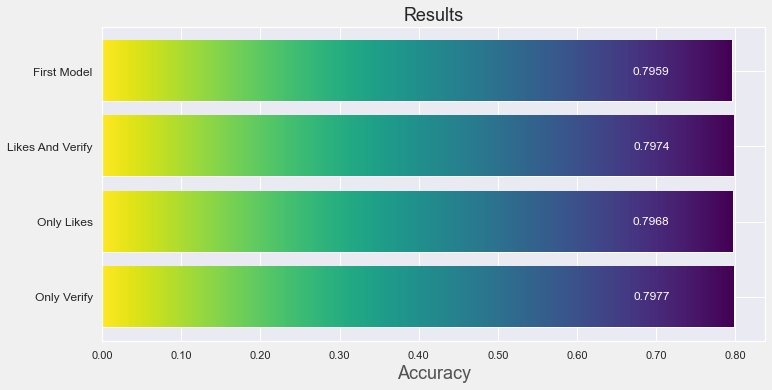

In [ ]:
pd.options.display.float_format = '{:,.0f}'.format
title_size = 18
index = pd.RangeIndex(start=0, stop=4, step=1)
values = [i for i in cv_final_scores.values()]
fig, ax = plt.subplots(figsize=(10,5), facecolor=(.94, .94, .94))
mpl.pyplot.viridis()
bar = ax.barh(index, values)
plt.tight_layout()
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))
title = plt.title('Results',  fontsize= title_size)

def gradientbars(bars):
    grad = np.atleast_2d(np.linspace(0,1,256))
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor('none')
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        ax.imshow(grad, extent=[x+w, x, y, y+h], aspect='auto', zorder=1)
    ax.axis(lim)
gradientbars(bar)
rects = ax.patches
# Place a label for each bar
for rect in rects:
    # Get X and Y placement of label from rect
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label; change to your liking
    space = -100
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: place label to the left of the bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label to the right
        ha = 'right'

    # Use X value as label and format number
    label = '{0:.4f}'.format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at bar end
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords='offset points', # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha,                      # Horizontally align label differently for positive and negative values
        color = 'white')            # Change label color to white

#Set x-label
ax.set_xlabel('Accuracy',fontsize=18, color='#525252')
ax.set_yticks(index,fontsize=12, labels=tuple(cv_final_scores))

### We got little higher result with the verified column, yay!!